In [1]:
# Importamos las librerias Python que usaremos
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# Cargamos los datos que hemos obtenido de la web de Kaggle
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
# Veamos algunos registros del fichero train
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Comprobamos los tipos de datos y la existencia de "missing values"
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Eliminamos las columnas que, a priori, carecen de interés para el análisis.
df_cleaned = df_train.loc[:, ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']]

# Hacemos lo mismo para el fichero de test.
df_test = df_test.loc[:, ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']]

In [6]:
# Vemos como queda el conjunto de datos después de eliminar las columnas indicadas.
df_cleaned.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,male,22.0,1,0,S
1,2,1,1,female,38.0,1,0,C
2,3,1,3,female,26.0,0,0,S
3,4,1,1,female,35.0,1,0,S
4,5,0,3,male,35.0,0,0,S


In [7]:
# Sustituimos los missing values del campo Embarked (sólo 2) por el mayoritariamente presente en el fichero.
df_cleaned['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [8]:
# Sustituimos los missing values de Embarked con el valor "S" que es el mayoritario.
df_cleaned['Embarked'] = df_cleaned['Embarked'].fillna('S')
# Seguimos el mismo criterio en el fichero de test.
df_test['Embarked'] = df_test['Embarked'].fillna('S')

In [9]:
# Sustituimos los missing values de Age por la mediana de las edades.
age_median = df_cleaned['Age'].median()
df_cleaned['Age'] = df_cleaned['Age'].fillna(age_median)
# Hacemos lo mismo para el fichero de test
age_median_t = df_test['Age'].median()
df_test['Age'] = df_test['Age'].fillna(age_median_t)

In [10]:
# Cambiamos la variable Sex por valores numéricos
df_cleaned['Sex'].replace(['male', 'female'], [0, 1], inplace = True)
# Lo cambiamos también en el fichero de test
df_test['Sex'].replace(['male', 'female'], [0, 1], inplace = True)

# Cambiamos la variable Age por valores numéricos (int64)
age2 = df_cleaned['Age'].copy()
df_cleaned['Age'] = age2.astype(int)
# También lo cambiamos en el fichero de test
age3 = df_test['Age'].copy()
df_test['Age'] = age3.astype(int)

# Cambiamos también los datos del puerto de embarque por números
df_cleaned['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace = True)
# Hacemos lo mismo en el fichero de test
df_test['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace = True)

# Vemos como queda el fichero después de los cambios
df_cleaned.info()
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null int32
SibSp          891 non-null int64
Parch          891 non-null int64
Embarked       891 non-null int64
dtypes: int32(1), int64(7)
memory usage: 52.3 KB


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,0,22,1,0,2
1,2,1,1,1,38,1,0,0
2,3,1,3,1,26,0,0,2
3,4,1,1,1,35,1,0,2
4,5,0,3,0,35,0,0,2


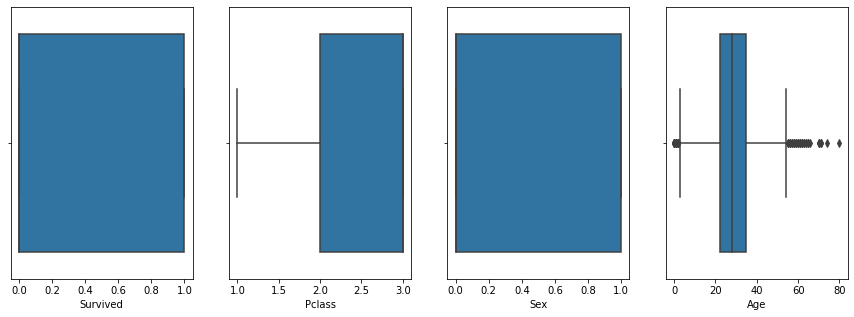

In [11]:
# Identificación y tratamiento de outliers
f = plt.figure(figsize = (15, 5));
plt.subplot(1,4,1)
sns.boxplot(x = df_cleaned['Survived'])
plt.subplot(1,4,2)
sns.boxplot(x = df_cleaned['Pclass'])
plt.subplot(1,4,3)
sns.boxplot(x = df_cleaned['Sex'])
plt.subplot(1,4,4)
sns.boxplot(x = df_cleaned['Age'])

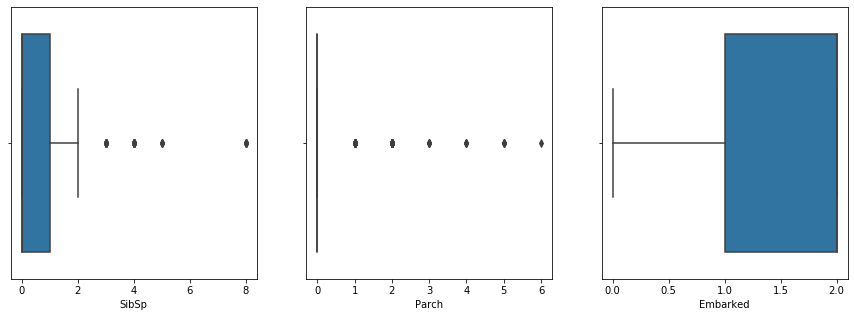

In [12]:
f = plt.figure(figsize = (15, 5));
plt.subplot(1,3,1)
sns.boxplot(x = df_cleaned['SibSp'])
plt.subplot(1,3,2)
sns.boxplot(x = df_cleaned['Parch'])
plt.subplot(1,3,3)
sns.boxplot(x = df_cleaned['Embarked'])

In [13]:
# Creamos intervalos de edades.
#bins = [0, 10, 18, 25, 40, 60, 100]
#names = ['1', '2', '3', '4', '5', '6']
#df_cleaned['Age'] = pd.cut(df_cleaned['Age'], bins, labels = names)
#df_test['Age'] = pd.cut(df_test['Age'], bins, labels = names)

# Comprobamos la nueva distribución de edades
#df_cleaned['Age'].value_counts()

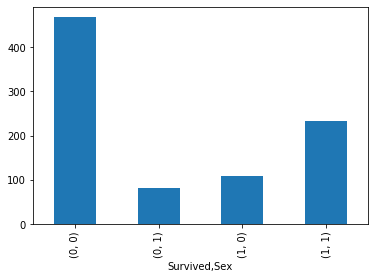

In [14]:
# Analizamos la distribución de salvados por sexo.
df_cleaned.groupby(['Survived','Sex']).count().PassengerId
df_cleaned.groupby(['Survived','Sex']).count().PassengerId.plot(kind='bar')

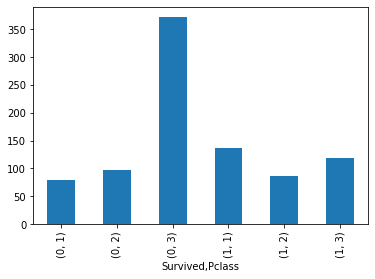

In [15]:
# Distribución de salvados por clase.
df_cleaned.groupby(['Survived','Pclass']).count().PassengerId
df_cleaned.groupby(['Survived','Pclass']).count().PassengerId.plot(kind='bar')

In [16]:
# Test de normalidad de Anderson-Darling
print('Test Anderson-Darling - Pclass: ')
result_anderson = scipy.stats.anderson(df_cleaned['Pclass'], dist = 'norm')
for i in range(len(result_anderson.critical_values)):
    sl, cv = result_anderson.significance_level[i], result_anderson.critical_values[i]
    if result_anderson.statistic < result_anderson.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

print('')
print('Test Anderson-Darling - Sex: ')
result_anderson = scipy.stats.anderson(df_cleaned['Sex'], dist = 'norm')
for i in range(len(result_anderson.critical_values)):
    sl, cv = result_anderson.significance_level[i], result_anderson.critical_values[i]
    if result_anderson.statistic < result_anderson.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

print('')
print('Test Anderson-Darling - SibSp: ')
result_anderson = scipy.stats.anderson(df_cleaned['SibSp'], dist = 'norm')
for i in range(len(result_anderson.critical_values)):
    sl, cv = result_anderson.significance_level[i], result_anderson.critical_values[i]
    if result_anderson.statistic < result_anderson.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

print('')
print('Test Anderson-Darling - Parch: ')
result_anderson = scipy.stats.anderson(df_cleaned['Parch'], dist = 'norm')
for i in range(len(result_anderson.critical_values)):
    sl, cv = result_anderson.significance_level[i], result_anderson.critical_values[i]
    if result_anderson.statistic < result_anderson.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

print('')
print('Test Anderson-Darling - Embarked: ')
result_anderson = scipy.stats.anderson(df_cleaned['Embarked'], dist = 'norm')
for i in range(len(result_anderson.critical_values)):
    sl, cv = result_anderson.significance_level[i], result_anderson.critical_values[i]
    if result_anderson.statistic < result_anderson.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Test Anderson-Darling - Pclass: 
15.000: 0.573, data does not look normal (reject H0)
10.000: 0.653, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.914, data does not look normal (reject H0)
1.000: 1.087, data does not look normal (reject H0)

Test Anderson-Darling - Sex: 
15.000: 0.573, data does not look normal (reject H0)
10.000: 0.653, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.914, data does not look normal (reject H0)
1.000: 1.087, data does not look normal (reject H0)

Test Anderson-Darling - SibSp: 
15.000: 0.573, data does not look normal (reject H0)
10.000: 0.653, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.914, data does not look normal (reject H0)
1.000: 1.087, data does not look normal (reject H0)

Test Anderson-Darling - Parch: 
15.000: 0.573, data does not look normal (reject H0)
10.000: 0.653, data does not lo

In [17]:
# Homogeneidad de varianzas mediante test de Fligner-Killeen
class1 = df_cleaned[df_cleaned['Pclass'] == '1']
class2 = df_cleaned[df_cleaned['Pclass'] == '2']
class3 = df_cleaned[df_cleaned['Pclass'] == '3']
stat1, pval1 = scipy.stats.fligner(class1, class2, class3, center = 'median')
stat2, pval2 = scipy.stats.fligner(class1, class2, class3, center = 'trimmed')
print(stat1, pval1)
print(stat2, pval2)

nan nan
nan nan


C:\Users\jordi\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [18]:
# Empezamos a construir modelos de Machine Learning
# Separamos la columna de Survived del fichero de entrenamiento.
X_train = df_cleaned.drop('Survived', axis = 1)
Y_train = df_cleaned['Survived']
X_test = df_test

In [19]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

C:\Users\jordi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


80.25

In [20]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

76.99

In [21]:
# Linear Support Vector Machine
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

C:\Users\jordi\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


48.6

In [22]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

100.0

In [23]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

In [24]:
# Análisis de Random Forest usando K-Fold Cross Validation
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.81111111 0.75555556 0.7752809  0.74157303 0.84269663 0.83146067
 0.82022472 0.80898876 0.83146067 0.82954545]
Mean: 0.8047897514470547
Standard Deviation: 0.03325569695923417


In [25]:
# Análisis de Decision Tree usando K-Fold Cross Validation
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.67777778 0.65555556 0.75280899 0.68539326 0.75280899 0.71910112
 0.78651685 0.7752809  0.82022472 0.80681818]
Mean: 0.7432286346612189
Standard Deviation: 0.05380916508013272


In [26]:
# Importancia de las variables en Random Forest.
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
PassengerId,0.277
Sex,0.272
Age,0.213
Pclass,0.112
SibSp,0.050
Parch,0.039
Embarked,0.037


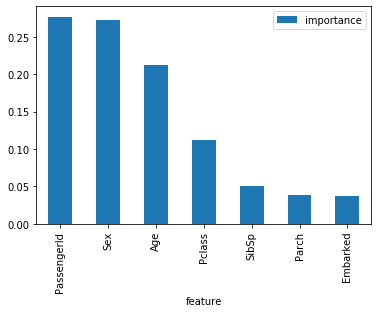

In [27]:
# Graficamos los resultados
importances.plot.bar()

In [28]:
# Matriz de confusión
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=10)
confusion_matrix(Y_train, predictions)

array([[470,  79],
       [104, 238]], dtype=int64)

In [29]:
# Precision and Recall
print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.750788643533123
Recall: 0.695906432748538


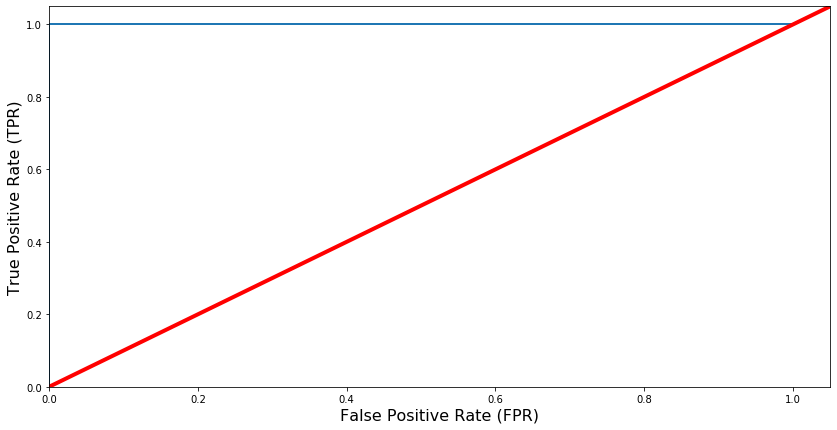

In [30]:
# Calculamos ROC AUC curve (true positive rate and false positive rate). Se dibujan uno contra otro.
# Calculamos las probabilidades de la predicción
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1.05], [0, 1.05], 'r', linewidth=4)
    plt.axis([0, 1.05, 0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [31]:
# Calculamos el ROC AUC Score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9999999999999999


In [32]:
# Convertir dataframe de entrenamiento tras los cambios a fichero csv.
df_cleaned.to_csv("train_final.csv", index = False)
print('Fichero guardado: train_final.csv')

Fichero guardado: train_final.csv


In [33]:
# Convertir dataframe de test tras los cambios a fichero csv.
df_test.to_csv("test_final.csv", index = False)
print('Fichero guardado: test_final.csv')

Fichero guardado: test_final.csv


In [35]:
# Convertir predicciones a fichero csv para envío a Kaggle.
def envio_kaggle_titanic(filename, predictions):
    envio_k = pd.DataFrame({'PassengerId':df_test['PassengerId'], 'Survived':predictions})
    envio_k.to_csv(filename, index = False)

# Llamo a la función con las predicciones realizadas cuando he evaluado el modelo Random Forest.
envio_kaggle_titanic("titanic_predictions.csv", Y_prediction)
print('Fichero guardado: titanic_predictions.csv')

Fichero guardado: titanic_predictions.csv
